In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade
!pip install -U openpyxl

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import pandas as pd
df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df.isnull().sum()
df.shape

(20800, 5)

In [4]:
df = df.dropna()

In [5]:
df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [6]:
df.shape

(18281, 5)

In [7]:
df = df.drop_duplicates().reset_index(drop=True)

In [8]:
df.shape

(18281, 5)

In [9]:
df['label'].value_counts()

,count
label,
0,10361
1,7920


##Data Analysis

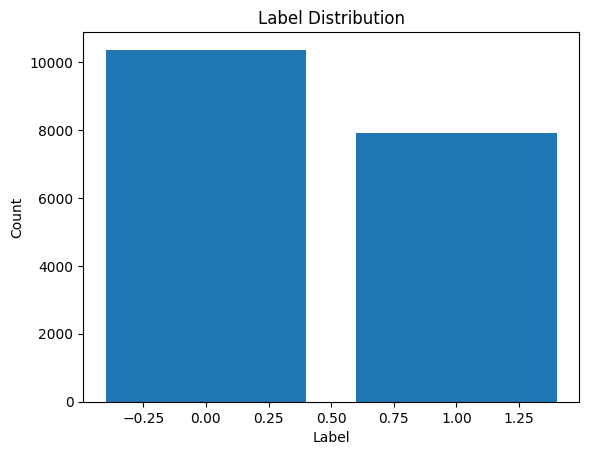

In [10]:
import matplotlib.pyplot as plt
label_counts = df['label'].value_counts(ascending=True)
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [11]:
# 1.5 tokens per word on average
df['title_tokens']=df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens']=df['text'].apply(lambda x: len(x.split())*1.5)

In [12]:
df.head()

,id,title,author,text,label,title_tokens,text_tokens
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,21.0,1230.0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,13.5,1065.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,10.5,1899.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15.0,835.5
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,21.0,231.0


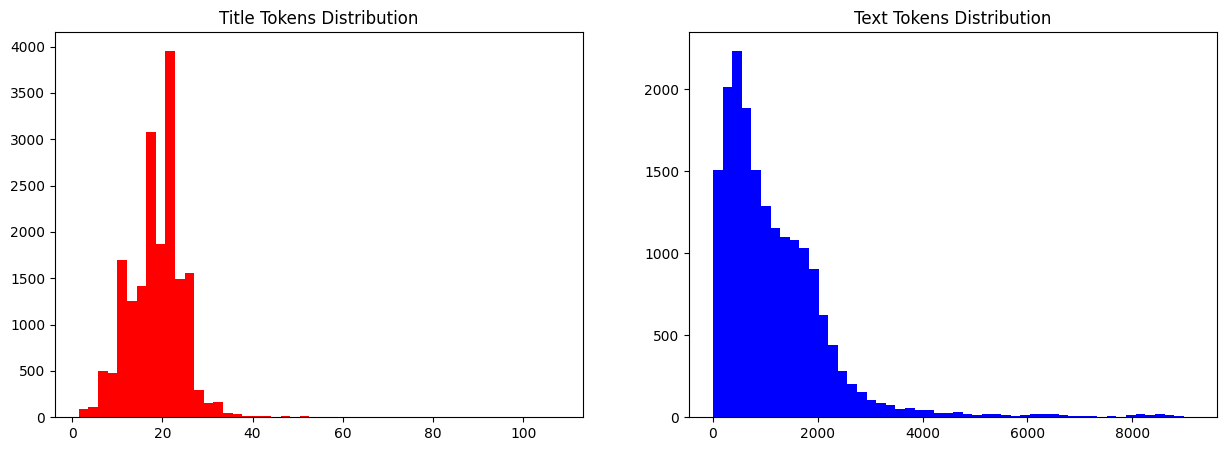

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(df['title_tokens'], bins=50, color='red')
ax[0].set_title('Title Tokens Distribution')
ax[1].hist(df['text_tokens'], bins=50, color='blue')
ax[1].set_title('Text Tokens Distribution')
plt.show()

Note : Text Tokens length has been exceeding 512 tokens as we can see in the chart, So title tokens would be ideal fit for predictions as in 'text' column text would be truncated.

##Data Loader and Train Test Split

In [14]:
from sklearn.model_selection import train_test_split
# 70% for training, 20% test, 10% validation

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
test_df, val_df = train_test_split(test_df, test_size=1/3, random_state=42, stratify=test_df['label'])

df.shape, train_df.shape, val_df.shape, test_df.shape

((18281, 7), (14624, 7), (1219, 7), (2438, 7))

In [15]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'test': Dataset.from_pandas(test_df, preserve_index=False),
    'validation': Dataset.from_pandas(val_df, preserve_index=False)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 14624
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 2438
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1219
    })
})

## Data Tokenization

In [16]:
from transformers import AutoTokenizer

text = "LLM has powered NLP in a really transformed manner."

model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)

model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [17]:
distilbert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=100

In [18]:
def tokenize(batch):
  temp = distilbert_tokenizer(batch['title'], truncation=True)
  return temp

print(tokenize(dataset['train'][0]))

{'input_ids': [101, 18520, 7207, 1999, 4121, 4390, 2044, 2637, 4384, 5305, 2518, 5023, 1999, 2023, 3861, 1012, 1012, 1012, 1008, 7044, 4898, 2739, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [19]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/14624 [00:00<?, ? examples/s]

Map:   0%|          | 0/2438 [00:00<?, ? examples/s]

Map:   0%|          | 0/1219 [00:00<?, ? examples/s]

##Model Buidling

In [20]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {
    "Real":0,
    "Fake":1
}
id2label = {
    0:"Real",
    1:"Fake"
}

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ckpt = "distilbert-base-uncased"
config = AutoConfig.from_pretrained(model_ckpt, num_labels=num_labels, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model.config.id2label

{0: 'Real', 1: 'Fake'}

In [22]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "vocab_size": 30522
}

In [23]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00


In [24]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

## Model Trainng

In [25]:
from logging import disable
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
    output_dir=training_dir,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    disable_tqdm=False,
    report_to="none"
)


In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=distilbert_tokenizer
)

In [27]:
trainer.train()

Step,Training Loss
500,0.297500


TrainOutput(global_step=914, training_loss=0.20871038875120734, metrics={'train_runtime': 119.5117, 'train_samples_per_second': 244.729, 'train_steps_per_second': 7.648, 'total_flos': 257756720147328.0, 'train_loss': 0.20871038875120734, 'epoch': 2.0})

## Model Evaluation

In [28]:
preds_output = trainer.predict(encoded_dataset['test'])
preds_output.metrics

{'test_loss': 0.09921221435070038,
 'test_accuracy': 0.9585726004922067,
 'test_runtime': 3.0389,
 'test_samples_per_second': 802.275,
 'test_steps_per_second': 25.338}

In [29]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test']['label']

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.96      0.97      0.96      1382
        Fake       0.96      0.95      0.95      1056

    accuracy                           0.96      2438
   macro avg       0.96      0.96      0.96      2438
weighted avg       0.96      0.96      0.96      2438



## Benchmarking

In [31]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics_eval(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

In [32]:
model_dict = {
    "bert-base" : "bert-base-uncased",
    "distilbert" : "distilbert-base-uncased",
    "mobilebert" : "google/mobilebert-uncased",
    "tinybert" : "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
  model_ckpt = model_dict[model_name]
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  config = AutoConfig.from_pretrained(model_ckpt, num_labels=num_labels, label2id=label2id, id2label=id2label)
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

  def local_tokenizer(batch):
    temp = tokenizer(batch['title'], padding=True, truncation=True)
    return temp

  encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

  trainer = Trainer(
      model=model,
      compute_metrics=compute_metrics_eval,
      args=training_args,
      train_dataset=encoded_dataset['train'],
      eval_dataset=encoded_dataset['validation'],
      tokenizer=tokenizer
  )
  trainer.train()
  preds_output = trainer.predict(encoded_dataset['test'])
  return preds_output.metrics


model_performance = {}
import time
for model_name in model_dict:
  print("\n\n")
  print(f"Model Name : {model_name}")
  start = time.time()
  result = train_model(model_name)
  end = time.time()
  model_performance[model_name] = {model_name : result, "Time Taken" : end-start}






Model Name : bert-base


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/14624 [00:00<?, ? examples/s]

Map:   0%|          | 0/2438 [00:00<?, ? examples/s]

Map:   0%|          | 0/1219 [00:00<?, ? examples/s]

Step,Training Loss
500,0.262100





Model Name : distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/14624 [00:00<?, ? examples/s]

Map:   0%|          | 0/2438 [00:00<?, ? examples/s]

Map:   0%|          | 0/1219 [00:00<?, ? examples/s]

Step,Training Loss
500,0.285100





Model Name : mobilebert


pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/14624 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/147M [00:00<?, ?B/s]

Map:   0%|          | 0/2438 [00:00<?, ? examples/s]

Map:   0%|          | 0/1219 [00:00<?, ? examples/s]

Step,Training Loss
500,175754.144000





Model Name : tinybert


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/14624 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Map:   0%|          | 0/2438 [00:00<?, ? examples/s]

Map:   0%|          | 0/1219 [00:00<?, ? examples/s]

Step,Training Loss
500,0.427200


In [33]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.10665508359670639,
   'test_accuracy': 0.9585726004922067,
   'test_f1': 0.958504748868289,
   'test_runtime': 10.1641,
   'test_samples_per_second': 239.864,
   'test_steps_per_second': 7.576},
  'Time Taken': 621.3374888896942},
 'distilbert': {'distilbert': {'test_loss': 0.10031517595052719,
   'test_accuracy': 0.9598031173092699,
   'test_f1': 0.9597502646430198,
   'test_runtime': 5.0922,
   'test_samples_per_second': 478.768,
   'test_steps_per_second': 15.121},
  'Time Taken': 295.3332061767578},
 'mobilebert': {'mobilebert': {'test_loss': 74.52912139892578,
   'test_accuracy': 0.8925348646431501,
   'test_f1': 0.8928970204406108,
   'test_runtime': 4.178,
   'test_samples_per_second': 583.532,
   'test_steps_per_second': 18.43},
  'Time Taken': 230.81496667861938},
 'tinybert': {'tinybert': {'test_loss': 0.14222048223018646,
   'test_accuracy': 0.9454470877768663,
   'test_f1': 0.9453577386087371,
   'test_runtime': 1.0678,
   'test_s

## Model Load & Save

In [34]:
trainer.save_model("Fake News")

In [35]:
from transformers import pipeline

classifier = pipeline("text-classification", model="Fake News")

Device set to use cuda:0


In [36]:
classifier("Iran Supreme Leader Ayotollah Khemnini was assassinated.")

[{'label': 'Fake', 'score': 0.694580614566803}]